In [1]:
import pandas as pd
import numpy as np
import pickle
import csv
from keras.datasets import mnist
import matplotlib.pyplot as plt
from PIL import Image

In [12]:
# Load the MNIST dataset, consisting of training and testing data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Scaling factor used for normalization, important to prevent overflow during exponentiation
Scaling = 255 # 255 is the maximum pixel value in grayscale images

# Get the dimensions (width and height) of the training images
WIDTH = X_train.shape[1] # Width of each image in pixels
HEIGHT = X_train.shape[2] # Height of each image in pixels

In [3]:
# # Reshape the data (X_train) from 3D images to 2D arrays and normalize it
X_train = X_train.reshape(X_train.shape[0],WIDTH*HEIGHT).T / Scaling
X_test = X_test.reshape(X_test.shape[0],WIDTH*HEIGHT).T  / Scaling

In [6]:
# Define batch size
batch_size = 128

# Calculate the total number of batches
num_batches = len(X_train) // batch_size

# Create mini-batches
mini_batches = []
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    mini_batch_X = X_train[start_idx:end_idx]
    mini_batch_Y = Y_train[start_idx:end_idx]
    mini_batches.append((mini_batch_X, mini_batch_Y))

# If there are any remaining data points, create one more mini-batch
if len(X_train) % batch_size != 0:
    mini_batch_X = X_train[num_batches * batch_size:]
    mini_batch_Y = Y_train[num_batches * batch_size:]
    mini_batches.append((mini_batch_X, mini_batch_Y))

In [8]:
# Define the Rectified Linear Unit (ReLU) activation function
def ReLU(Z):
    return np.maximum(Z,0)

# Compute the derivative of the ReLU activation function
def derivative_ReLU(Z):
    return Z > 0

# Define the softmax activation function
def softmax(Z):
    # Compute softmax values for each sets of scores in x.
    exp = np.exp(Z - np.max(Z)) #the np.max(Z) avoids an overflow by reducing the content of exp
    return exp / exp.sum(axis=0)

# Initialize neural network parameters (weights and biases)
def init_params(nodes,size):
    # Initialize weights (W1 and W2) and biases (b1 and b2) with random values
    W1 = np.random.rand(nodes,size) * np.sqrt(1./(size))
    b1 = np.random.rand(nodes,1) * np.sqrt(1./nodes)
    W2 = np.random.rand(nodes,nodes) * np.sqrt(1./nodes)
    b2 = np.random.rand(nodes,1) * np.sqrt(1./(size))
    return W1,b1,W2,b2

# Perform forward propagation through the neural network
def forward_propagation(X,W1,b1,W2,b2):
    Z1 = W1.dot(X) + b1 # Calculate the first layer's weighted sum (10, m)
    A1 = ReLU(Z1) # Apply ReLU activation to the first layer (10,m)
    Z2 = W2.dot(A1) + b2 # Calculate the second layer's weighted sum (10,m)
    A2 = softmax(Z2) # Apply softmax activation to the second layer (10,m)
    return Z1, A1, Z2, A2

# Create a one-hot encoding of target labels Y
def one_hot(Y,nodes):
    # return 0 vector with 1 only for the position corresponding to the value in Y 
    one_hot_Y = np.zeros((nodes, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y

Perform backward propagation to compute gradients
def backward_propagation(nodes,X, Y, A1, A2, W2, Z1, m):
    one_hot_Y = one_hot(Y,nodes)
    dZ2 = 2*(A2 - one_hot_Y) # Calculate the gradient of the second layer (nodes,m)
    dW2 = 1/m * (dZ2.dot(A1.T)) # Compute the weight gradients for the second layer (nodes , nodes)
    db2 = 1/m * np.sum(dZ2,axis=1, keepdims=True) # Compute the bias gradients for the second layer (nodes, 1)
    dZ1 = W2.T.dot(dZ2)*derivative_ReLU(Z1) # Calculate the gradient of the first layer (nodes, m)
    dW1 = 1/m * (dZ1.dot(X.T)) # Compute the weight gradients for the first layer (nodes, size)
    db1 = 1/m * np.sum(dZ1,axis=1, keepdims=True) # Compute the bias gradients for the first layer (nodes, 1)

    return dW1, db1, dW2, db2

# Update model parameters using gradient descent
def update_params(nodes,alpha, W1, b1, W2, b2, dW1, db1, dW2, db2):
    W1 -= alpha * dW1 # Update the first layer weights
    b1 -= alpha * np.reshape(db1, (nodes,1)) # Update the first layer biases
    W2 -= alpha * dW2 # Update the second layer weights
    b2 -= alpha * np.reshape(db2, (nodes,1)) # Update the second layer biases

    return W1, b1, W2, b2

In [ ]:
# # Get predictions by finding the index with the highest value in A2
def get_predictions(A2):
    return np.argmax(A2, 0)

# Calculate the accuracy of predictions compared to ground truth labels
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y)/Y.size

# Implement gradient descent training with mini-batches
def gradient_descent(X, Y, alpha, iterations,batch_size):
    size , m = X.shape
    nodes = 512

    # Initialize model parameters
    W1, b1, W2, b2 = init_params(nodes,size)
    for i in range(iterations):
        # Mini-batch training
        for batch_start in range(0, m, batch_size):
            batch_end = min(batch_start + batch_size, m)
            X_batch = X[:, batch_start:batch_end]
            Y_batch = Y[batch_start:batch_end]
        # Forward propagation    
        Z1, A1, Z2, A2 = forward_propagation(X, W1, b1, W2, b2)
        # Backward propagation
        dW1, db1, dW2, db2 = backward_propagation(nodes,X, Y, A1, A2, W2, Z1, m)
        # Update model parameters
        W1, b1, W2, b2 = update_params(nodes,alpha, W1, b1, W2, b2, dW1, db1, dW2, db2)   

        if (i+1) % int(iterations/10) == 0:
            print(f"Iteration: {i+1} / {iterations}")
            prediction = get_predictions(A2)
            print(f'{get_accuracy(prediction, Y):.3%}')
    return W1, b1, W2, b2

In [ ]:
# Function to make predictions using the trained model
def make_predictions(X, W1 ,b1, W2, b2):
    # Perform forward propagation to get predictions from the model
    _, _, _, A2 = forward_propagation(X, W1, b1, W2, b2)
    # Get the class predictions based on the highest probability in A2
    predictions = get_predictions(A2)
    return predictions

# Function to display a prediction along with the actual label
def show_prediction(index,X, Y, W1, b1, W2, b2):
    # None => creates a new axis of dimension 1, this has the effect of transposing X[:,index] which is an np.array of dimension 1 (row) and which becomes a vector (column) 
    # ...which corresponds well to what is requested by make_predictions which expects a matrix whose columns are the pixels of the image, there we give a single column
    # Extract the image data for the specified index
    vect_X = X[:, index,None]
    # Get the prediction for the image using the model
    prediction = make_predictions(vect_X, W1, b1, W2, b2)
    # Get the actual label from the ground truth
    label = Y[index]
    # Print the prediction and label
    print("Prediction: ", prediction)
    print("Label: ", label)

    # Reshape the image data and scale it for display
    current_image = vect_X.reshape((WIDTH, HEIGHT)) * Scaling

    # Display the image using matplotlib
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [9]:
# Perform gradient descent to train the neural network model
# Parameters:
# - X_train: Training input data
# - Y_train: Training labels
# - 0.15: Learning rate
# - 200: Number of iterations (epochs)
# - batch_size: Size of mini-batches for training

W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.15, 200,batch_size)

# Save the trained model parameters (weights and biases) to a pickle file
# This allows you to reuse the trained model without retraining
with open("trained_params.pkl","wb") as dump_file:
    pickle.dump((W1, b1, W2, b2),dump_file)

Iteration: 20 / 200
48.205%
Iteration: 40 / 200
60.473%
Iteration: 60 / 200
79.817%
Iteration: 80 / 200
85.078%
Iteration: 100 / 200
88.278%
Iteration: 120 / 200
89.665%
Iteration: 140 / 200
90.307%
Iteration: 160 / 200
90.753%
Iteration: 180 / 200
91.170%
Iteration: 200 / 200
91.498%


Prediction:  [4]
Label:  4


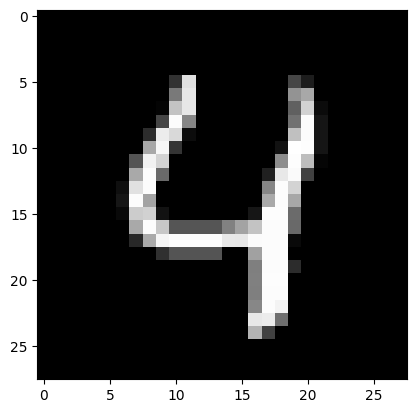

Prediction:  [7]
Label:  7


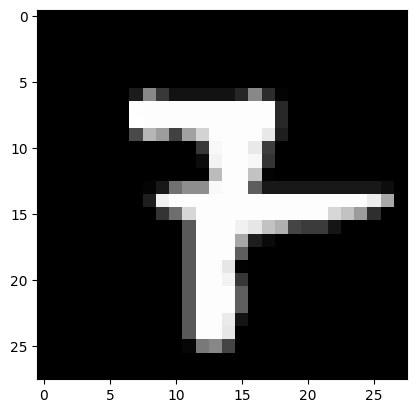

Prediction:  [4]
Label:  4


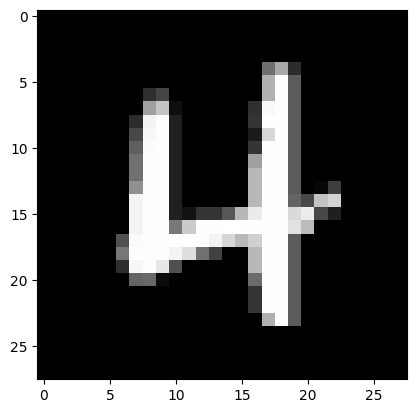

In [10]:
# Load the trained model parameters from a pickle file
with open("trained_params.pkl","rb") as dump_file:
    W1, b1, W2, b2=pickle.load(dump_file)

# Display predictions for several test images
show_prediction(4,X_test, Y_test, W1, b1, W2, b2)
show_prediction(97,X_test, Y_test, W1, b1, W2, b2)
show_prediction(533,X_test, Y_test, W1, b1, W2, b2)

In [11]:
# Make predictions on the test dataset using the trained model parameters
dev_predictions = make_predictions(X_test, W1, b1, W2, b2)

# Calculate the accuracy of the model on the test dataset
accuracy = get_accuracy(dev_predictions, Y_test)
print(f"Accuracy on the test dataset: {accuracy:.3%}")

Accuracy on the test dataset: 91.450%
